In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [23]:
%matplotlib inline

# Objective
The objective is to showcase how to use a train/test split with python in a machine learning pipeline. I'll use an open database (iris) but it shouldn't be hard to generalize this to your problem

#### Load data

In [5]:
iris = datasets.load_iris()

In [7]:
print(iris.DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

Here are your features: 150 observations (subjects), 4 features (variables). This is your "X"

In [55]:
print(iris.data.shape)
print(iris.feature_names)

(150, 4)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


Here is your target, which are classes. This is your "y"

In [18]:
print(iris.target.shape)
print(list(zip(np.unique(iris.target),
               iris.target_names)))

(150,)
[(0, 'setosa'), (1, 'versicolor'), (2, 'virginica')]


#### (stratified) train-test split
Here, we will separate the data into two groups. A 70% training set and a 30% test set. We will also shuffle the data first so it's unsorted, and we will set the random state so that the shuffle returns the same results every time. Finally, we will make sure we stratify the data, meaning there are equal proportions of our classes in training and test. You could stratify on cohort/tracer if you wanted.

In [21]:
tr_X, te_X, tr_y, te_y = train_test_split(iris.data, iris.target,
                                         test_size=0.3, # 30% left out
                                          shuffle=True, # shuffle first
                                         stratify=iris.target, # stratify
                                         random_state=123) # set state

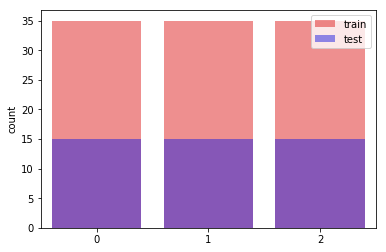

In [29]:
### Showing the stratification works:
sns.countplot(tr_y,color='red',alpha=0.5,label='train')
sns.countplot(te_y,color='blue',alpha=0.5, label='test')
plt.legend()
plt.show()

#### Train a model on the training data only, using cross-validation
I'll just use a simple linear logistic regression model because they tend to work best in small datasets like the ones you and I have. Linear SVC works pretty well too. But you seemed to want an L1-regularized (i.e. sparse) model, and that's an option with Logistic Regression



In [34]:
mod = LogisticRegressionCV(cv=10,penalty='l1',solver='liblinear',
                           random_state=123)

In [35]:
## Use cross-validation on training sample...
predicted = cross_val_predict(mod,tr_X,tr_y)

## get accuracy
acc = accuracy_score(tr_y,predicted)

print('Model accuracy: {}'.format(acc))

Model accuracy: 0.9523809523809523


In [36]:
print(classification_report(tr_y,predicted))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        35
          1       0.92      0.94      0.93        35
          2       0.94      0.91      0.93        35

avg / total       0.95      0.95      0.95       105



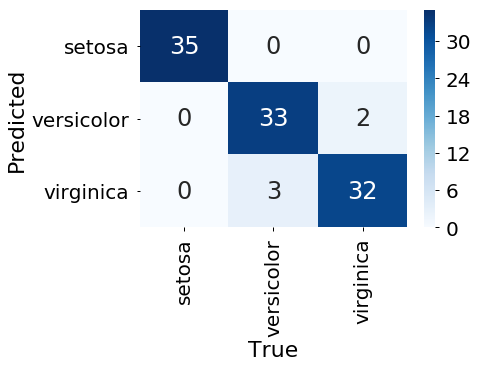

In [48]:
sns.set_context('notebook',font_scale=2)
g = sns.heatmap(confusion_matrix(tr_y,predicted),
            cmap='Blues',
            annot=True)
plt.xlabel('True')
plt.ylabel('Predicted')
g.set_xticklabels(iris.target_names, rotation=90)
g.set_yticklabels(iris.target_names, rotation=0)

#### Test it on the left out data
In reality, we might want to keep tweaking our model in the training set until we're happy with it. Here, I'm perfectly happy -- we're at 95%! But for the purposes of this example, I'll just move on to the test set

In [50]:
mod = LogisticRegressionCV(cv=10,penalty='l1',solver='liblinear',
                           random_state=123) # redefine model to prevent
                                             # "leakage"
mod.fit(tr_X,tr_y) # fit to all training data
predicted = mod.predict(te_X) # predict left out data
acc = accuracy_score(te_y, predicted) # assess accuracy
print("Accuracy of model on left-out data: {}".format(acc))

Accuracy of model on left-out data: 0.9333333333333333


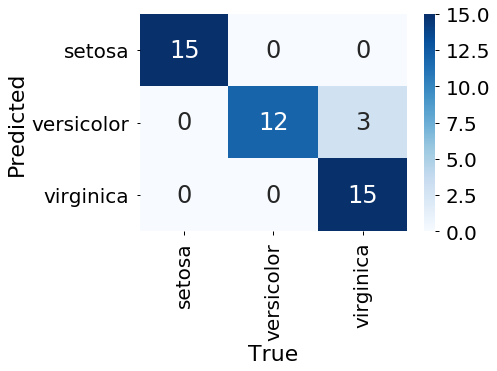

In [52]:
sns.set_context('notebook',font_scale=2)
g = sns.heatmap(confusion_matrix(te_y,predicted),
            cmap='Blues',
            annot=True)
plt.xlabel('True')
plt.ylabel('Predicted')
g.set_xticklabels(iris.target_names, rotation=90)
g.set_yticklabels(iris.target_names, rotation=0)

#### Examine the feature
Now that we are satisfied with the efficacy of our model, we can look at the feature weights. Interpreting feature weights is actually a whole can of worms, but for the purposes of simplicity, let's just have a look

In [56]:
mod = LogisticRegressionCV(cv=10,penalty='l1',solver='liblinear',
                           random_state=123) # redefine model
mod.fit(iris.data,iris.target) # fit model on all data
weights = mod.coef_ # get feature weights

In this example, we had three classes, so we actually end up with three sets of feature weights

In [64]:
weight_df = pd.DataFrame(weights,index = iris.target_names,
                         columns = iris.feature_names)
weight_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
setosa,0.000000,0.640101,-0.864496,0.000000
versicolor,0.000000,-2.366247,1.013317,-2.190738
virginica,-2.560334,-4.462181,6.562184,11.586311


In [65]:
# visualize
stacked = weight_df.stack()
stacked = stacked.reset_index()
stacked.columns = ['class','feature','weight']
stacked

,class,feature,weight
0,setosa,sepal length (cm),0.000000
1,setosa,sepal width (cm),0.640101
2,setosa,petal length (cm),-0.864496
3,setosa,petal width (cm),0.000000
4,versicolor,sepal length (cm),0.000000
5,versicolor,sepal width (cm),-2.366247
6,versicolor,petal length (cm),1.013317
7,versicolor,petal width (cm),-2.190738
8,virginica,sepal length (cm),-2.560334
9,virginica,sepal width (cm),-4.462181


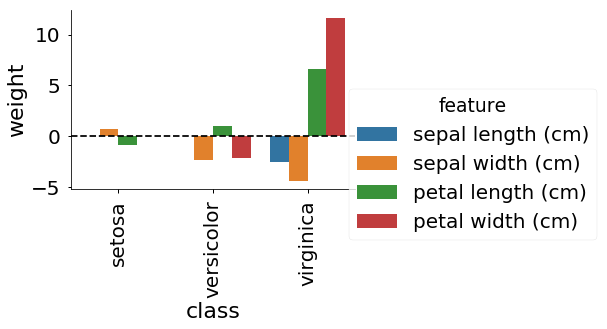

In [73]:
g = sns.factorplot(x='class',y='weight',hue='feature',
                   data=stacked, aspect=1.5,kind='bar')
g.set_xticklabels(rotation=90)
plt.axhline(0,ls='--',c='black')